In [2]:
# Import libraries and dependencies
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns

#downloading from google sheets
import gspread 
from oauth2client.service_account import ServiceAccountCredentials

#preparing to send to Google Sheets
from pandas.io.json import json_normalize

%matplotlib inline

In [3]:
# Set the file paths
whale_data = Path("./Resources/whale_returns.csv")
algo_data = Path("./Resources/algo_returns.csv")
sp500_data = Path("./Resources/sp500_history.csv")

# aapl_data = Path("./Resources/aapl_historical.csv")
# cost_data = Path("./Resources/cost_historical.csv")
# goog_data = Path("./Resources/goog_historical.csv")

# Read the CSVs and set the `date` column as a datetime index to the DataFrame
whale_df = pd.read_csv(whale_data, index_col="Date", \
    infer_datetime_format=True, parse_dates=True)
algo_df = pd.read_csv(algo_data, index_col="Date", \
    infer_datetime_format=True, parse_dates=True)
sp500_df = pd.read_csv(sp500_data, index_col="Date", \
    infer_datetime_format=True, parse_dates=True)

# Sort datetime index in ascending order (past to present) 
whale_df.sort_index(inplace=True)
algo_df.sort_index(inplace=True)
sp500_df.sort_index(inplace=True)

# aapl_df = pd.read_csv(aapl_data, index_col="Trade DATE", infer_datetime_format=True, parse_dates=True)
# cost_df = pd.read_csv(cost_data, index_col="Trade DATE", infer_datetime_format=True, parse_dates=True)
# goog_df = pd.read_csv(goog_data, index_col="Trade DATE", infer_datetime_format=True, parse_dates=True)

# Display a few rows
whale_df.head()

,SOROS FUND MANAGEMENT LLC,PAULSON & CO.INC.,TIGER GLOBAL MANAGEMENT LLC,BERKSHIRE HATHAWAY INC
Date,,,,
2015-03-02,NaN,NaN,NaN,NaN
2015-03-03,-0.001266,-0.004981,-0.000496,-0.006569
2015-03-04,0.002230,0.003241,-0.002534,0.004213
2015-03-05,0.004016,0.004076,0.002355,0.006726
2015-03-06,-0.007905,-0.003574,-0.008481,-0.013098


In [4]:
# dropping nulls
whale_df.dropna(inplace=True)
algo_df.dropna(inplace=True)
sp500_df.dropna(inplace=True)

In [5]:
# remove non-numeric symbols ($ and ,) , then convert to float
# sp500_df
sp500_df['Close'] = sp500_df['Close'].str.replace(',', '')
sp500_df['Close'] = sp500_df['Close'].str.replace('$', '')
sp500_df['Close'] = sp500_df['Close'].astype(float)

/var/folders/wc/dzcyrwqx2r18c1qvj6l_bc540000gn/T/ipykernel_58194/2665572392.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  sp500_df['Close'] = sp500_df['Close'].str.replace('$', '')


In [6]:
# create daily returns from the closing price of sp500
sp500_df_dr = sp500_df.pct_change()
sp500_df_dr.rename(columns={"Close": "S&P TSX"}, inplace=True)
sp500_df_dr.sort_index(inplace=True)
sp500_df_dr.head()

,S&P TSX
Date,
2012-10-01,NaN
2012-10-02,0.000872
2012-10-03,0.003624
2012-10-04,0.007174
2012-10-05,-0.000322


In [7]:
# Use the `concat` function to combine the DataFrames by matching indexes (or in this case `date`)
combined_df_list=[whale_df,algo_df,sp500_df_dr]
combined_df = pd.concat(combined_df_list, axis=1, join="inner", sort=True)
combined_df.head()

,SOROS FUND MANAGEMENT LLC,PAULSON & CO.INC.,TIGER GLOBAL MANAGEMENT LLC,BERKSHIRE HATHAWAY INC,Algo 1,Algo 2,S&P TSX
Date,,,,,,,
2015-03-03,-0.001266,-0.004981,-0.000496,-0.006569,-0.001942,-0.000949,-0.004539
2015-03-04,0.002230,0.003241,-0.002534,0.004213,-0.008589,0.002416,-0.004389
2015-03-05,0.004016,0.004076,0.002355,0.006726,-0.000955,0.004323,0.001196
2015-03-06,-0.007905,-0.003574,-0.008481,-0.013098,-0.004957,-0.011460,-0.014174
2015-03-09,0.000582,0.004225,0.005843,-0.001652,-0.005447,0.001303,0.003944


<AxesSubplot:title={'center':'Daily Returns of S&P 500 2015-2019'}, xlabel='Date'>

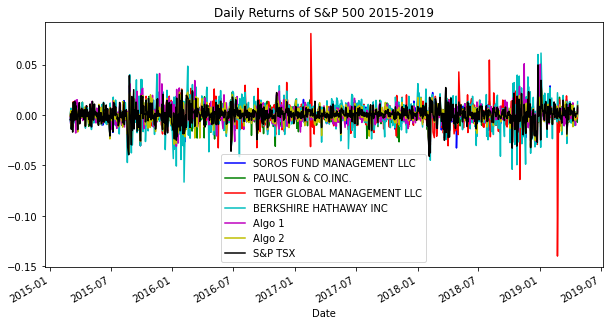

In [8]:
# for col in combined_df.columns:
#     print(col)
    
# Plot the daily returns of all the portfolios
cmb_df_sfm=combined_df['SOROS FUND MANAGEMENT LLC']
cmb_df_pci=combined_df['PAULSON & CO.INC. ']
cmb_df_tgm=combined_df['TIGER GLOBAL MANAGEMENT LLC']
cmb_df_bhi=combined_df['BERKSHIRE HATHAWAY INC']
cmb_df_alg1=combined_df['Algo 1']
cmb_df_alg2=combined_df['Algo 2']
cmb_df_sptx=combined_df['S&P TSX']
cmb_df_sfm.plot (figsize=(10,5), title="Daily Returns of Soros 2015-2019",color='b', legend=True,)
cmb_df_pci.plot (figsize=(10,5),title="Daily Returns of Paulson 2015-2019",color='g', legend=True)
cmb_df_tgm.plot (figsize=(10,5),title="Daily Returns of Tiger Global 2015-2019",color='r', legend=True)
cmb_df_bhi.plot (figsize=(10,5),title="Daily Returns of Berkshire Hathaway 2015-2019",color='c', legend=True)
cmb_df_alg1.plot (figsize=(10,5),title="Daily Returns of Algo 1 2015-2019",color='m', legend=True)
cmb_df_alg2.plot (figsize=(10,5),title="Daily Returns of Algo 2 2015-2019",color='y', legend=True)
cmb_df_sptx.plot (figsize=(10,5),title="Daily Returns of S&P 500 2015-2019",color='k', legend=True)


<AxesSubplot:title={'center':'Cumulative Returns of S&P 500 2015-2019'}, xlabel='Date'>

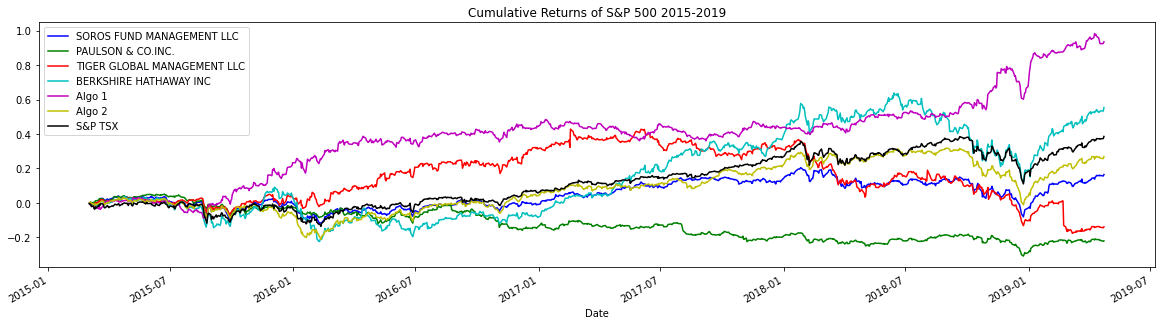

In [10]:
# Plot the cumulative returns of all the portfolios
# Calculate the cumulative returns using the 'cumprod()' function
cum_rtn_sfm = (1 + cmb_df_sfm).cumprod() - 1
cum_rtn_pci = (1 + cmb_df_pci).cumprod() - 1
cum_rtn_tgm = (1 + cmb_df_tgm).cumprod() - 1
cum_rtn_bhi = (1 + cmb_df_bhi).cumprod() - 1
cum_rtn_alg1 = (1 + cmb_df_alg1).cumprod() - 1
cum_rtn_alg2 = (1 + cmb_df_alg2).cumprod() - 1
cum_rtn_sptx = (1 + cmb_df_sptx).cumprod() - 1
cum_rtn_sfm.plot(figsize=(20,5), title="Cumulative Returns of Soros 2015-2019",color='b', legend=True)
cum_rtn_pci.plot(figsize=(20,5), title="Cumulative Returns of Paulson 2015-2019",color='g', legend=True)
cum_rtn_tgm.plot(figsize=(20,5), title="Cumulative Returns of Tiger Global 2015-2019",color='r', legend=True)
cum_rtn_bhi.plot(figsize=(20,5), title="Cumulative Returns of Berkshire Hathaway 2015-2019",color='c', legend=True)
cum_rtn_alg1.plot(figsize=(20,5), title="Cumulative Returns of Algo 1  2015-2019",color='m', legend=True)
cum_rtn_alg2.plot(figsize=(20,5), title="Cumulative Returns of Algo 2 2015-2019", color='y', legend=True)
cum_rtn_sptx.plot(figsize=(20,5), title="Cumulative Returns of S&P 500 2015-2019", color='k', legend=True)

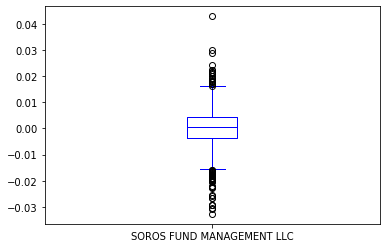

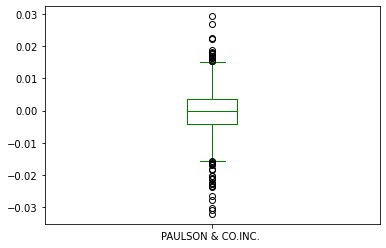

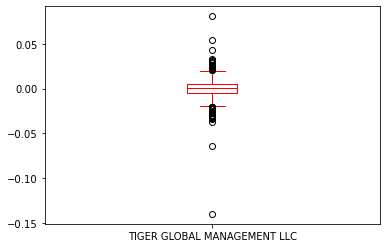

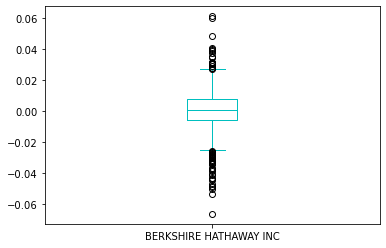

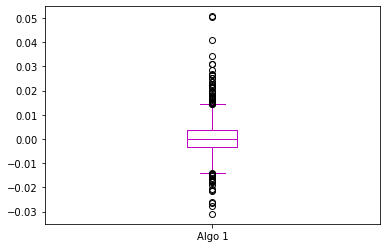

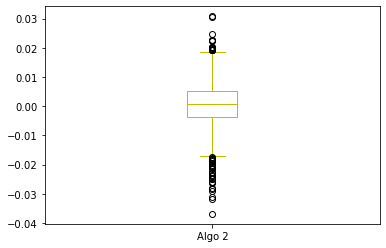

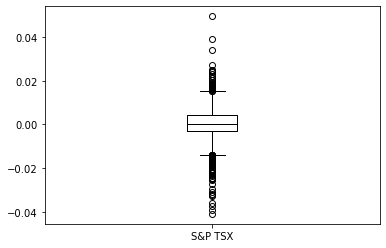

In [59]:
#Create a box plot for each of the returns
cmb_df_sfm_df=cmb_df_sfm.to_frame()
cmb_df_pci_df=cmb_df_pci.to_frame()
cmb_df_tgm_df=cmb_df_tgm.to_frame()
cmb_df_bhi_df=cmb_df_bhi.to_frame()
cmb_df_alg1_df=cmb_df_alg1.to_frame()
cmb_df_alg2_df=cmb_df_alg2.to_frame()
cmb_df_sptx_df=cmb_df_sptx.to_frame()
boxplot_sfm = cmb_df_sfm_df.plot.box(color='b',subplots=True)
boxplot_pci = cmb_df_pci_df.plot.box(color='g',subplots=True)
boxplot_tgm = cmb_df_tgm_df.plot.box(color='r',subplots=True)
boxplot_bhi = cmb_df_bhi_df.plot.box(color='c',subplots=True)
boxplot_alg1 = cmb_df_alg1_df.plot.box(color='m',subplots=True)
boxplot_alg2 = cmb_df_alg2_df.plot.box(color='y',subplots=True)
boxplot_sptx = cmb_df_sptx_df.plot.box(color='k',subplots=True)

In [15]:
#calculate Standard Deviation for each portfolio
cmb_df_sfm_df_std=cmb_df_sfm_df.std()
cmb_df_pci_df_std=cmb_df_pci_df.std()
cmb_df_tgm_df_std=cmb_df_tgm_df.std()
cmb_df_bhi_df_std=cmb_df_bhi_df.std()
cmb_df_alg1_df_std=cmb_df_alg1_df.std()
cmb_df_alg2_df_std=cmb_df_alg2_df.std()
cmb_df_sptx_df_std=cmb_df_sptx_df.std()
#
combined_new_df_list=[cmb_df_sfm_df_std,
                      cmb_df_pci_df_std,
                      cmb_df_tgm_df_std,
                      cmb_df_bhi_df_std,
                      cmb_df_alg1_df_std,
                      cmb_df_alg2_df_std,
                      cmb_df_sptx_df_std]
combined_new_df = pd.concat(combined_new_df_list, axis=0, join="inner", sort=True)
# shows all the standard deviations
combined_new_df.head(7)
#filters the top 3 standard deviations , or the riskiest
combined_new_df_dict=combined_new_df.to_dict()
sort_cmd_new_dct=sorted(combined_new_df_dict, key=combined_new_df_dict.get, reverse=True)[:3]
sort_cmd_new_dct
#'BERKSHIRE HATHAWAY INC', 'TIGER GLOBAL MANAGEMENT LLC' are riskier than the S&P 500

['BERKSHIRE HATHAWAY INC', 'TIGER GLOBAL MANAGEMENT LLC', 'S&P TSX']

In [16]:
#Calculate the annualized standard deviation
cmb_df_sfm_df_std_ann=cmb_df_sfm_df.std()*np.sqrt(252)
cmb_df_pci_df_std_ann=cmb_df_pci_df.std()*np.sqrt(252)
cmb_df_tgm_df_std_ann=cmb_df_tgm_df.std()*np.sqrt(252)
cmb_df_bhi_df_std_ann=cmb_df_bhi_df.std()*np.sqrt(252)
cmb_df_alg1_df_std_ann=cmb_df_alg1_df.std()*np.sqrt(252)
cmb_df_alg2_df_std_ann=cmb_df_alg2_df.std()*np.sqrt(252)
cmb_df_sptx_df_std_ann=cmb_df_sptx_df.std()*np.sqrt(252)
#
combined_new_df_list_ann=[cmb_df_sfm_df_std_ann,
                      cmb_df_pci_df_std_ann,
                      cmb_df_tgm_df_std_ann,
                      cmb_df_bhi_df_std_ann,
                      cmb_df_alg1_df_std_ann,
                      cmb_df_alg2_df_std_ann,
                      cmb_df_sptx_df_std_ann]
combined_new_df_ann = pd.concat(combined_new_df_list_ann, axis=0, join="inner", sort=True)
combined_new_df_ann.head(7)

SOROS FUND MANAGEMENT LLC      0.125335
PAULSON & CO.INC.              0.111488
TIGER GLOBAL MANAGEMENT LLC    0.172936
BERKSHIRE HATHAWAY INC         0.205077
Algo 1                         0.120967
Algo 2                         0.132430
S&P TSX                        0.135786
dtype: float64

array([<AxesSubplot:xlabel='Date'>], dtype=object)

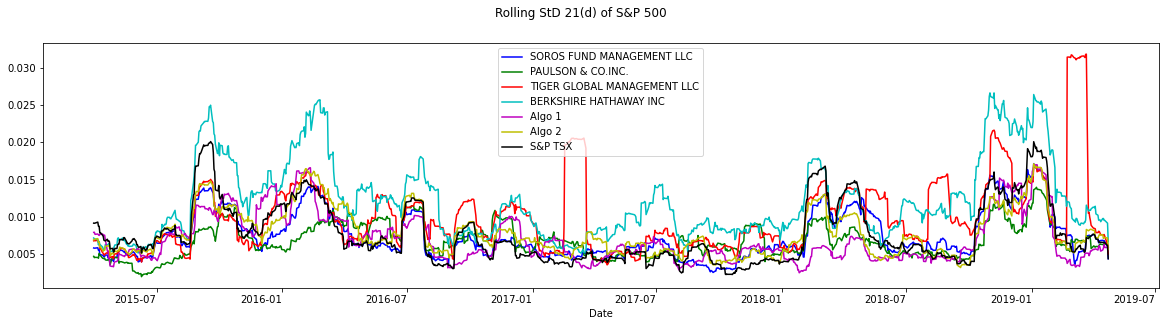

In [17]:
#Calculate and plot the rolling standard deviation for all portfolios, using a 21-day window
cmb_df_sfm=combined_df['SOROS FUND MANAGEMENT LLC']
cmb_df_pci=combined_df['PAULSON & CO.INC. ']
cmb_df_tgm=combined_df['TIGER GLOBAL MANAGEMENT LLC']
cmb_df_bhi=combined_df['BERKSHIRE HATHAWAY INC']
cmb_df_alg1=combined_df['Algo 1']
cmb_df_alg2=combined_df['Algo 2']
cmb_df_sptx=combined_df['S&P TSX']
#
cmb_df_sfm.rolling(window=21).std().plot(figsize=(20,5),title="Rolling StD 21(d) of Soros",color='b', legend=True, subplots=True)
cmb_df_pci.rolling(window=21).std().plot(figsize=(20,5),title="Rolling StD 21(d) of PAULSON ",color='g', legend=True, subplots=True)
cmb_df_tgm.rolling(window=21).std().plot(figsize=(20,5),title="Rolling StD 21(d) of Tiger ",color='r', legend=True, subplots=True)
cmb_df_bhi.rolling(window=21).std().plot(figsize=(20,5),title="Rolling StD 21(d) of Berkshire ",color='c', legend=True, subplots=True)
cmb_df_alg1.rolling(window=21).std().plot(figsize=(20,5),title="Rolling StD 21(d) of Algo 1 ",color='m', legend=True, subplots=True)
cmb_df_alg2.rolling(window=21).std().plot(figsize=(20,5),title="Rolling StD 21(d) of Algo 2 ",color='y', legend=True, subplots=True)
cmb_df_sptx.rolling(window=21).std().plot(figsize=(20,5),title="Rolling StD 21(d) of S&P 500 ",color='k', legend=True, subplots=True)

<AxesSubplot:>

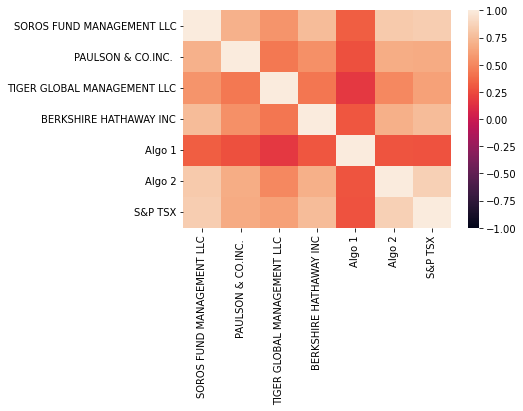

In [18]:
#Calculate and plot the correlation between each stock(?) Portfolio
correlation=combined_df.corr()
# correlation.head(7)
sns.heatmap(correlation, vmin=-1, vmax=1)
#Soros mimics the S&P the most

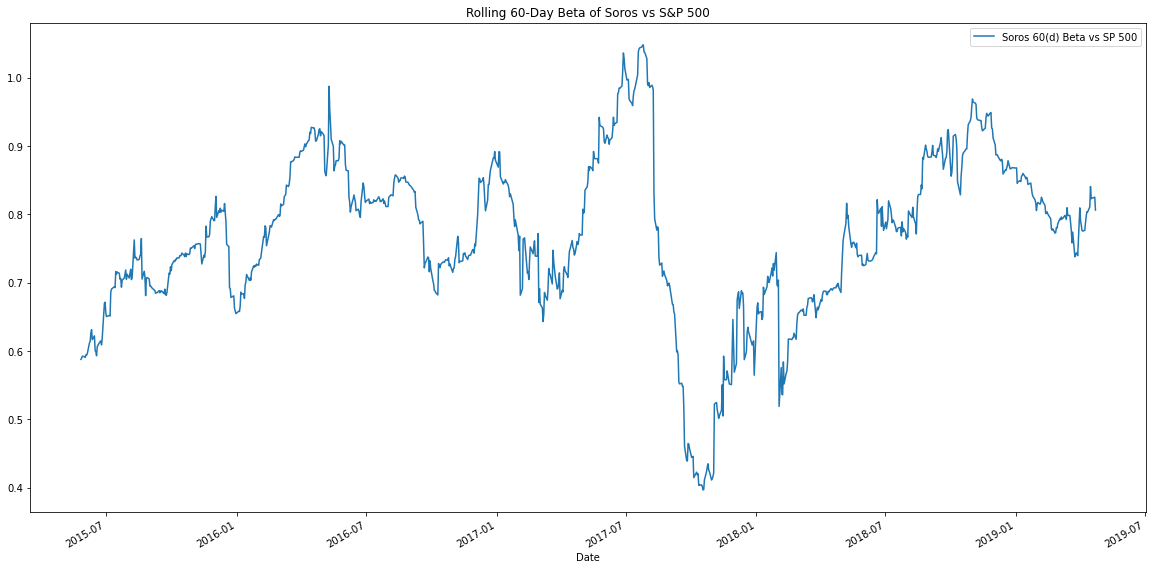

In [19]:
#Choose one portfolio, then calculate and plot the 60-day rolling beta between that portfolio and the S&P 500

# Calculate covariance of all daily returns of Soros vs. S&P 500
soros_covariance = combined_df['SOROS FUND MANAGEMENT LLC'].cov(combined_df['S&P TSX'])
# Calculate variance of all daily returns of Soros vs. S&P 500
variance = combined_df['S&P TSX'].var()
# Calculate beta of all daily returns of Soros 
soros_beta = soros_covariance / variance
# print(f"Soros Beta Value: {soros_beta}")

rolling_soros_covariance = combined_df['SOROS FUND MANAGEMENT LLC'].rolling(window=60).cov(combined_df['S&P TSX'])
# Calculate 30-day rolling variance of S&P 500
rolling_variance = combined_df['S&P TSX'].rolling(window=60).var()
# Calculate 30-day rolling beta of AMZN and plot the data
rolling_soros_beta = rolling_soros_covariance / rolling_variance
#plot
ax = rolling_soros_beta.plot(figsize=(20, 10), title='Rolling 60-Day Beta of Soros vs S&P 500',legend=True)
ax.legend(["Soros 60(d) Beta vs SP 500"])

#Exponentially Weighted Average
cmb_df_sfm=combined_df['SOROS FUND MANAGEMENT LLC']
cmb_df_sptx=combined_df['S&P TSX']
soros_ewm = cmb_df_sfm.ewm(halflife=21).mean().cov(cmb_df_sptx)
sptx_ewm = cmb_df_sptx
soros_ewm_ratio = soros_ewm / sptx_ewm
# soros_ewm_ratio
# ax_ewm_soros=soros_ewm_ratio.plot(figsize=(20, 10),legend=True)
# ax_ewm_soros.legend(["Soros EWM vs SP 500"])

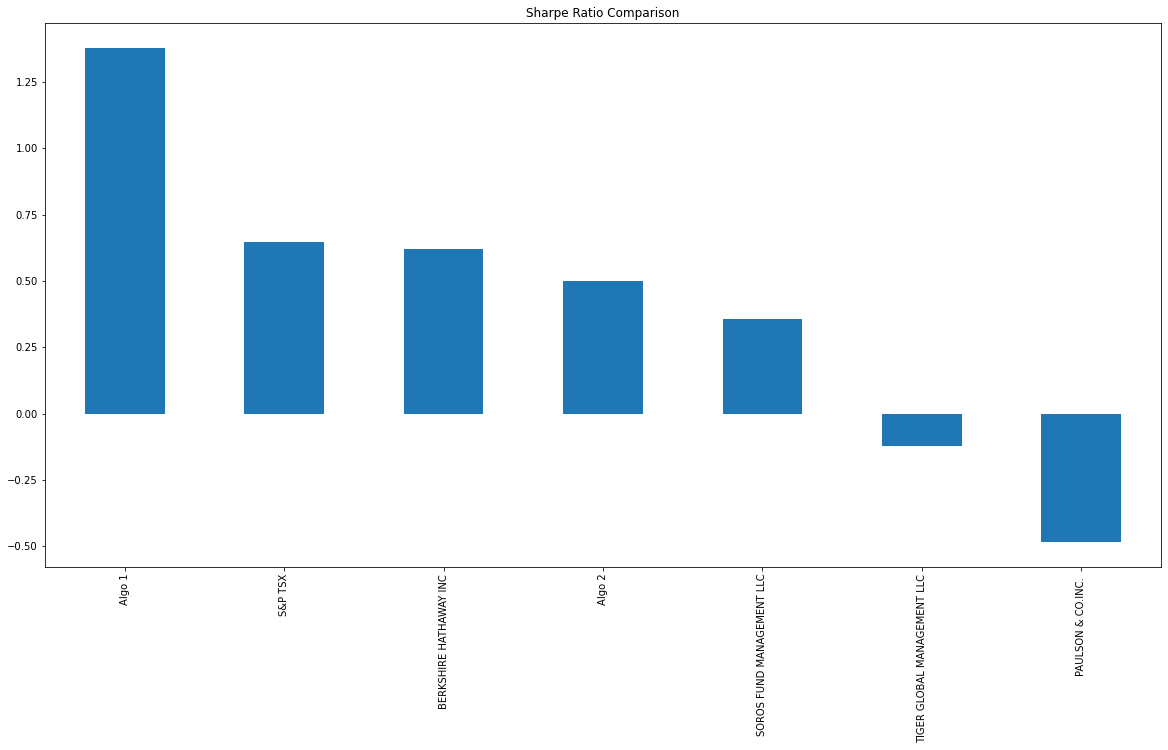

In [57]:
#calculate the Sharpe ratios and visualize them in a bar plot

#all portfolios
noncorrelated_daily_returns = combined_df

# Use the `mean` and `std` functions to calculate the annualized sharpe ratio
sharpe_ratios = (noncorrelated_daily_returns.mean() * 252) / (noncorrelated_daily_returns.std() * np.sqrt(252))
sharpe_ratios.sort_values(ascending=False, inplace=True)

sharpe_ratios_dict=sharpe_ratios.to_dict()
# sharpe_ratios
ax_sharpe_ratios = sharpe_ratios.plot.bar(figsize=(20, 10), title='Sharpe Ratio Comparison')
#Algo 1 out performs the market and the whales portfolios

In [62]:
#part 3 - Create a custom Portfolio
# Connect to our service account
scope = ['https://spreadsheets.google.com/feeds']
credentials = ServiceAccountCredentials.from_json_keyfile_name('./sa_cred.json', scope)
gc = gspread.authorize(credentials)
##Get candidate data sheet from Google Drive
spreadsheet_key = '1dQNs-d9fFF4j6sZQjORiP1BhkZbmLnzHxW6toTA6NQU'
book = gc.open_by_key(spreadsheet_key)

In [78]:
#connect to nike worksheet
nike_ws = book.worksheet("Nike")
nike_table = nike_ws.get_all_values()
##Convert table data into a dataframe
nike_df = pd.DataFrame(nike_table[1:], columns=nike_table[0])
##Only keep columns we need
nike_df = nike_df[['Date', 'Close']]
##Convert number strings to floats and ints
nike_df = nike_df.apply(pd.to_numeric, errors='ignore')
##Convert date strings to datetime format
nike_df['Date'] = pd.to_datetime(nike_df['Date'],infer_datetime_format=True)

nike_df.set_index('Date', inplace=True)
nike_df.rename(columns={"Close": "Nike"}, inplace=True)
nike_df.head()

,Nike
Date,
2015-01-02 16:00:00,47.52
2015-01-05 16:00:00,46.75
2015-01-06 16:00:00,46.48
2015-01-07 16:00:00,47.44
2015-01-08 16:00:00,48.53


In [79]:
#connect to Amazon worksheet
amzn_ws = book.worksheet("Amazon")
amzn_table = amzn_ws.get_all_values()
##Convert table data into a dataframe
amzn_df = pd.DataFrame(amzn_table[1:], columns=amzn_table[0])
##Only keep columns we need
amzn_df = amzn_df[['Date', 'Close']]
##Convert number strings to floats and ints
amzn_df = amzn_df.apply(pd.to_numeric, errors='ignore')
##Convert date strings to datetime format
amzn_df['Date'] = pd.to_datetime(amzn_df['Date'],infer_datetime_format=True)
amzn_df.set_index('Date', inplace=True)
amzn_df.rename(columns={"Close": "Amazon"}, inplace=True)
amzn_df.head()

,Amazon
Date,
2015-01-02 16:00:00,15.43
2015-01-05 16:00:00,15.11
2015-01-06 16:00:00,14.76
2015-01-07 16:00:00,14.92
2015-01-08 16:00:00,15.02


In [80]:
#connect to AMD worksheet
amd_ws = book.worksheet("AMD")
amd_table = amd_ws.get_all_values()
##Convert table data into a dataframe
amd_df = pd.DataFrame(amd_table[1:], columns=amd_table[0])
##Only keep columns we need
amd_df = amd_df[['Date', 'Close']]
##Convert number strings to floats and ints
amd_df = amd_df.apply(pd.to_numeric, errors='ignore')
##Convert date strings to datetime format
amd_df['Date'] = pd.to_datetime(amd_df['Date'],infer_datetime_format=True)
amd_df.set_index('Date', inplace=True)
amd_df.rename(columns={"Close": "Amd"}, inplace=True)
amd_df.head()

,Amd
Date,
2015-01-02 16:00:00,2.69
2015-01-05 16:00:00,2.66
2015-01-06 16:00:00,2.63
2015-01-07 16:00:00,2.58
2015-01-08 16:00:00,2.61


In [86]:
#Calculate the annualized standard deviation for the custome portfolio
combined_goog_df_list=[nike_df,amzn_df,amd_df]
combined_goog_df = pd.concat(combined_goog_df_list, axis=1, join="inner", sort=True)
combined_goog_df.head()
cmb_df_nke=combined_goog_df['Nike']
cmb_df_amzn=combined_goog_df['Amazon']
cmb_df_amd=combined_goog_df['Amd']
#
cmb_df_nke_df=cmb_df_nke.to_frame()
cmb_df_amzn_df=cmb_df_amzn.to_frame()
cmb_df_amd_df=cmb_df_amd.to_frame()
cmb_df_nke_df_std_ann=cmb_df_nke_df.std()*np.sqrt(252)
cmb_df_amzn_df_std_ann=cmb_df_amzn_df.std()*np.sqrt(252)
cmb_df_amd_df_std_ann=cmb_df_amd_df.std()*np.sqrt(252)
#
combined_new_df_list_ann=[cmb_df_nke_df_std_ann,
                      cmb_df_amzn_df_std_ann,
                      cmb_df_amd_df_std_ann]
combined_new_df_ann = pd.concat(combined_new_df_list_ann, axis=0, join="inner", sort=True)
combined_new_df_ann.head(3)

Nike      559.478809
Amazon    812.683935
Amd       621.875751
dtype: float64

In [ ]:
# Calculate and plot the rolling standard deviation with a 21-day window.
# Calculate and plot the correlation.
# Calculate and plot beta for your portfolio compared to the S&P 60 TSX.
# Calculate the Sharpe ratios and generate a bar plot.